# Example YOLOv2 detector

This notebook shows the complete pipeline for creating and training a new model for `faces` detection (trained on the `Wider Faces` dataset).

## Imports + model initialization

The 1st step is to create the model. Note that the `nb_class` attribute in the configuration corresponds to the number of possible class to detect. It must be greater than 1 (if not, will automatically be set to 2). 

If you put it higher than the real number of classes, it allows you to add new object later which can beinteresting ! (pay attention that if you try it you will need to train on both (new and old classes) otherwise your model will become poor on old classes). 

In [1]:
import pandas as pd
import tensorflow as tf

from utils import plot, plot_multiple, set_display_options, limit_gpu_memory
from datasets import get_dataset, prepare_dataset, test_dataset_time, train_test_split
from models.detection import YOLO

set_display_options()
#limit_gpu_memory()

input_size = 416
model_name = 'yolo_face'
print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.3.2


In [2]:
config = {
    'input_size' : input_size,
    'backend'    : 'full_yolo',
    'nb_class'   : 5,
    'max_box_per_image' : 100,
    'labels'     : ['face'],
}
model = YOLO(nom = model_name, ** config)

print(model)

Loading weights from pretrained_models/yolo_backend/full_yolo_backend.h5
Initializing submodel : model !
Submodel model saved in pretrained_models\yolo_face\saving\model.json !
Model yolo_face initialized successfully !

========== yolo_face ==========
Sub model model
- Inputs 	: (None, 416, 416, 3)
- Outputs 	: (None, 13, 13, 5, 10)
- Number of layers 	: 76
- Number of parameters 	: 50.599 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

Labels (n = 5) : ['face', '', '', '', '']
Feature extractor : full_yolo



## Model instanciation + dataset loading

Once the model has been created, you can instanciate it simply by its name without putting all configuration again !

Optimizers and config are tuned for a good training on `Wider Faces` but you can easily change their value. It seems that `sgd` is better than `adam` for this model because it sometimes leads to `NaN loss` (I don't know why but it seems to not appear with `SGD`).

Next you have to load the dataset (which must be downloaded on your laptop). Note that the `drop(index = 79)` is for the `kangaroo` dataset because this specific image seems to not be correctly formatted for tensorflow image decoding (why ?). 

In [2]:
model = YOLO(nom = model_name)

model.compile(
    optimizer = 'sgd',
    optimizer_config = {
        'lr' : {'name' : 'WarmupScheduler', 'maxval' : 5e-3,'minval' : 1e-4, 'factor' : 1024, 'warmup_steps' : 4096}
    },
    loss_config = {'warmup_epochs' : 3}
)

print(model)

Model restoration...
Initializing submodel : model !
Optimizer 'model_optimizer' initilized successfully !
Submodel model compiled !
  Loss : {'reduction': 'none', 'name': None, 'anchors': array([0.57273 , 0.677385, 1.87446 , 2.06253 , 3.33843 , 5.47434 ,
       7.88282 , 3.52778 , 9.77052 , 9.16828 ], dtype=float32), 'object_scale': 5.0, 'no_object_scale': 1.0, 'coord_scale': 1.0, 'class_scale': 1.0, 'warmup_epochs': 3}
  Optimizer : {'name': 'SGD', 'learning_rate': {'class_name': 'WarmupScheduler', 'config': {'factor': 1024.0, 'warmup_steps': 4096, 'minval': 0.0001, 'maxval': 0.005}}, 'decay': 0.0, 'momentum': 0.0, 'nesterov': False}
  Metrics : []
Successfully restored model from pretrained_models/yolo_face/saving/model.json !
Model yolo_face initialized successfully !
Model model is already compiled !

========== yolo_face ==========
Sub model model
- Inputs 	: (None, 416, 416, 3)
- Outputs 	: (None, 13, 13, 5, 10)
- Number of layers 	: 76
- Number of parameters 	: 50.599 Millions


In [3]:
# `rectangular_boxes` is for boxes padding (required for batching)
dataset_name = 'wider'
dataset = get_dataset(
    dataset_name, max_box_per_image = model.max_box_per_image, rectangular_boxes = True
)

if isinstance(dataset, dict):
    train, valid = dataset['train'], dataset['valid']
else:
    train, valid = train_test_split(dataset, train_size = 0.75, shuffle = True)
    if dataset_name == 'kangaroo': train = train.drop(index = 79)

print('Train size : {} - Valid size : {}'.format(len(train), len(valid)))

Loading dataset wider...
Train size : 12638 - Valid size : 3167


## Training + history analysis

Here is the training call : you can easily change this configuration. 

The `train_times > 1` seems to be interesting for the `warmup_epochs`' loss configuration. 

When the loss becomes less than 0.2 / 0.15 the model seems to be quite good and usable but I suggest you to train it till < 0.1 loss (if possible) which seems to bea really performing model. The providedmodel has afinal loss of 0.07 and is relatively well stable and performant.

If you want to make a fast test to see results of your own trained model, I suggest you to use the `kangaroo` dataset which gives good results after 10 epochs (less than 10min) with results shown below, really funny and encourageant for a 1st model !

In [9]:
epochs = 25
batch_size = 16

model.train(
    train, validation_data = valid,
    train_times = 2, epochs = epochs, batch_size = batch_size,
    augment_prct = 0.4, shuffle_size = 9192
)

Training config :
HParams :
- augment_prct	: 0.4
- augment_methods	: ['hue', 'brightness', 'saturation', 'contrast', 'noise']
- epochs	: 100
- batch_size	: 16
- valid_batch_size	: 32
- test_batch_size	: 1
- verbose	: 1
- train_times	: 2
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1
- shuffle_size	: 9192

Epoch 76/100
      2/Unknown - 0s 178ms/step - loss: 0.1454 - loss_xy: 0.0893 - loss_wh: 0.0544 - loss_conf: 0.0017 - loss_class: 1.3992e-06WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1340s vs `on_train_batch_end` time: 0.2220s). Check your callbacks.
   1580/Unknown - 583s 369ms/step - loss: 0.1778 - loss_xy: 0.0846 - loss_wh: 0.0911 - loss_conf: 0.0020 - loss_class: 1.4530e-04
Saving at epoch 76 !
1580/1580 [==============================] - 631s 399ms/step - loss: 0.1778 - loss_xy: 0.0846 - loss_wh: 0.0911 - loss_conf: 0.0020 - loss_class: 1.4535e-04 - val_loss: 0.2206 - val_l

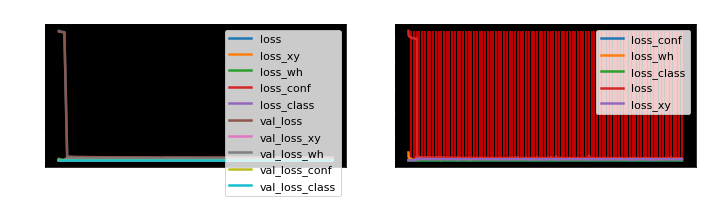

In [10]:
model.plot_history()

## Prediction

1 boxes found :
0.5469 0.2356 0.3697 0.3780 0 0.4138


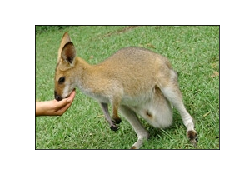

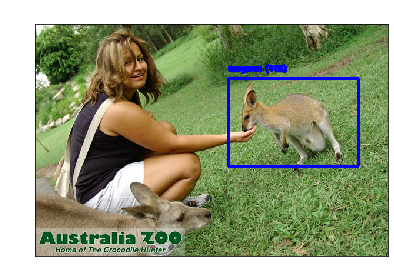

1 boxes found :
0.0417 0.0605 0.4601 0.7365 0 0.3645


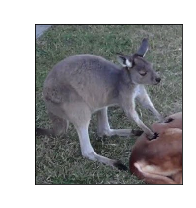

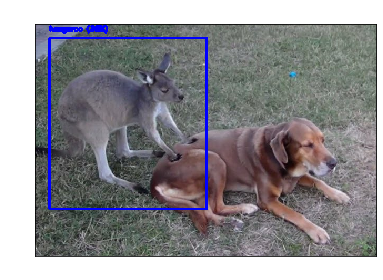

5 boxes found :
0.4869 0.0000 0.5131 0.3537 0 0.4029
0.0787 0.0697 0.3921 0.8636 0 0.4193
0.6666 0.4061 0.2733 0.4970 0 0.3647
0.0085 0.5576 0.2100 0.3464 0 0.3949
0.4288 0.4950 0.2895 0.4773 0 0.3503


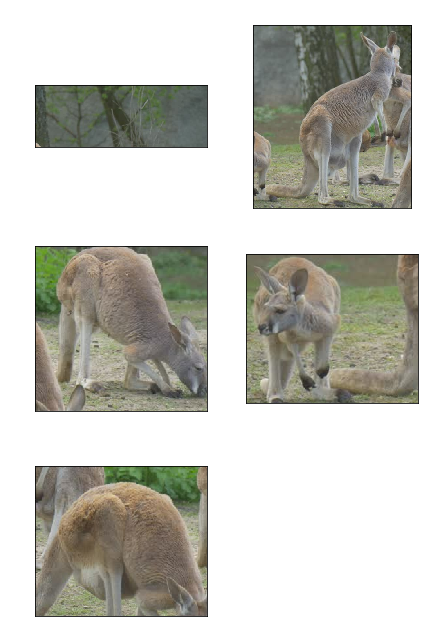

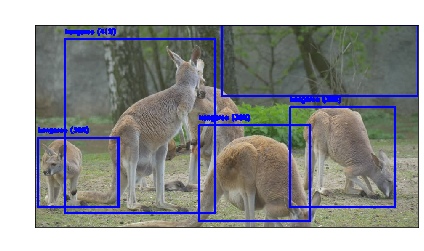

3 boxes found :
0.6673 0.0000 0.3327 0.3465 0 0.4073
0.0000 0.0000 0.4664 0.4967 0 0.3846
0.2507 0.0879 0.5041 0.8243 0 0.3836


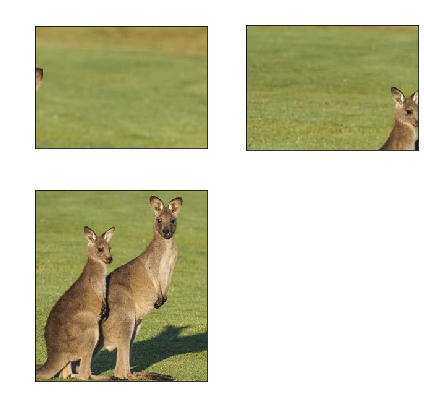

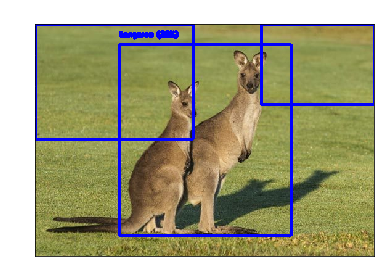

1 boxes found :
0.1098 0.1092 0.6349 0.6282 0 0.3887


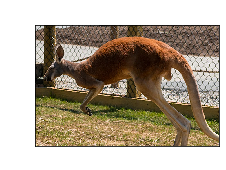

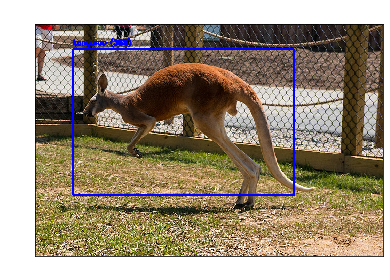

Total time : 3.383 sec
- Processing time : 0.055 sec
- Inference time : 0.107 sec
- Show time : 3.221 sec
- Saving time : 0.000 sec


In [7]:
samples = valid.sample(5, random_state = 0)

_ = model.predict(list(samples['filename'].values), save = False, debug = True, verbose = 3, obj_threshold = 0.35)

1 boxes found :
0.3120 0.1236 0.3157 0.4168 0 0.8039


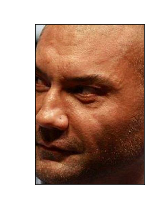

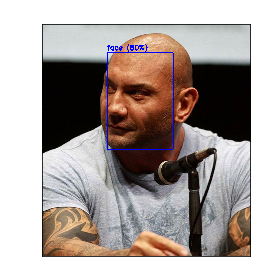

1 boxes found :
0.4742 0.1487 0.0506 0.0703 0 0.6077


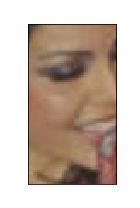

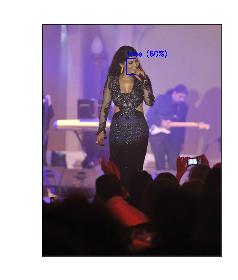

1 boxes found :
0.7839 0.3824 0.0550 0.0592 0 0.6636


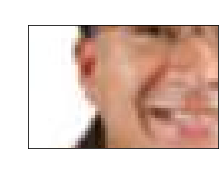

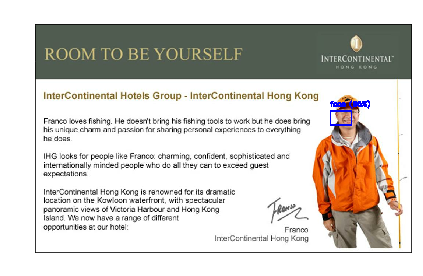

5 boxes found :
0.7648 0.2306 0.1024 0.1147 0 0.4030
0.7831 0.3017 0.0519 0.0656 0 0.4009
0.1634 0.4716 0.0585 0.0530 0 0.3722
0.3163 0.4574 0.0573 0.0596 0 0.7191
0.4604 0.4292 0.1124 0.1079 0 0.7902


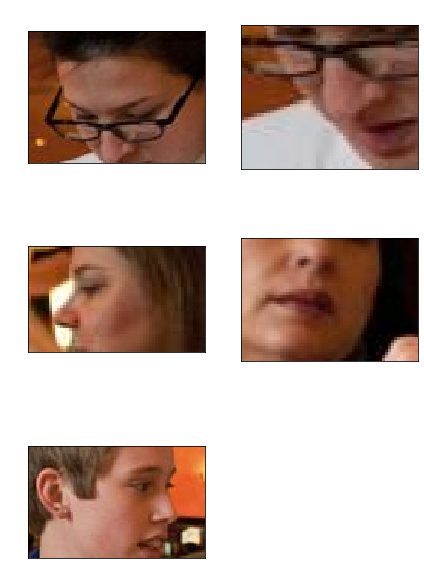

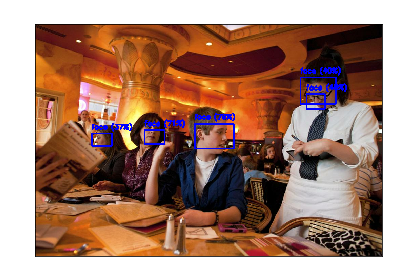

1 boxes found :
0.3262 0.2449 0.0434 0.0434 0 0.5557


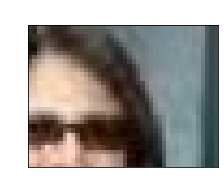

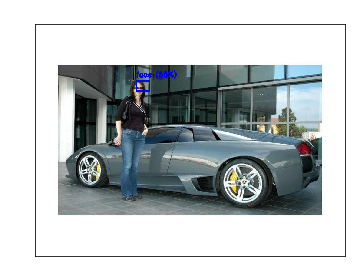

Total time : 4.386 sec
- Processing time : 0.393 sec
- Inference time : 0.090 sec
- Show time : 3.902 sec
- Saving time : 0.000 sec


In [11]:
samples = valid.sample(5, random_state = 0)

_ = model.predict(list(samples['filename'].values), save = False, debug = True, verbose = 3, obj_threshold = 0.35)

1 boxes found :
0.3854 0.3679 0.2760 0.3932 0 0.8282


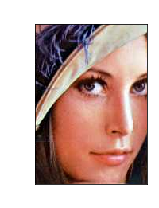

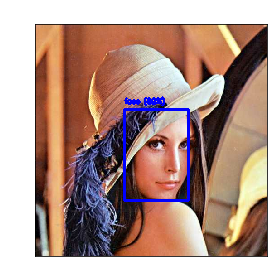

Total time : 0.458 sec
- Processing time : 0.005 sec
- Inference time : 0.035 sec
- Show time : 0.418 sec
- Saving time : 0.000 sec


In [12]:
_ = model.predict('lena.jpg', save = False, debug = True, verbose = 3, show = True, obj_threshold = 0.35)

### Detection on video

The `predict` function internally calls `predict_video` for `.mp4` files. The `debug` argument allows to see time for processing, inference and saving. As you can see, for a `30sec` video, it is 2 times faster than real time (`inference time`) but saving takes a lot of time especially `save_detected = True` which saves every frame with detection boxes. If you just save video (`save_video = True`) it becomes real time (around 28sec for processing + saving). 

Note : the `MoviePy` call is to copy the audio from original video to the video with detection boxes

In [3]:
_ = model.predict(
    'my_video.mp4', save_video = True, save_detected = True, save_frames = False, 
    debug = True, overwrite = True, verbose = 3, obj_threshold = 0.3, batch_size = 64
)

[MoviePy] Writing audio in audio_tmp.mp3


100%|███████████████████████████████████████████████████████████████████████████████| 804/804 [00:01<00:00, 569.81it/s]

[MoviePy] Done.


Total time : 47.908 sec
- Processing time : 8.714 sec
- Inference time : 14.568 sec
- Show time : 0.000 sec
- Saving time : 24.626 sec
Total time : 0.001 sec
- Processing time : 0.000 sec
- Inference time : 0.000 sec
- Show time : 0.000 sec
- Saving time : 0.001 sec


## Streaming

**WARNING** : before running this cell, make sureto uncomment the `limit_gpu_memory` in the 1st cell (imports) before initializing the model. If you forgot it, I highly recommand you to restart your jupyter kernel, uncomment the line and re-load your model (you do not have to retrain it, obviously ;) just execute 1st cell (imports) and 3rd one (model instanciation) then this one).

In [ ]:
model.stream(max_time = 5, save = True, save_boxes = True, overwrite = False)

## Configure `learning-rate scheduler`

This cell allows you to play with `learning_rate scheduler`'s parameters to get the one you want !

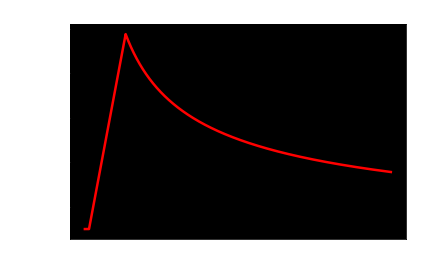

In [12]:
lr = model.model_optimizer.learning_rate
lr.factor = 1024.
lr.warmup_steps = 1024
lr.plot(512 * 15)

## Test dataset performances

In [ ]:
config = model.get_dataset_config(is_validation = True, batch_size = 16)

ds_train = prepare_dataset(train, ** config, debug = True)
test_dataset_time(ds_train)